In [1]:
import json
from copy import copy
import matplotlib.pyplot as plt
import yaml
import optuna
import numpy as np
from optuna.samplers import CmaEsSampler, TPESampler

from utils import denoise_small_values, generate_sinc_filter, generate_filter, oversample
from snn.resonator import test_resonator_on_chirp, lf_lp_options

In [89]:
from snn.spiking_network import SpikingNetwork
from snn.layers import SCTNLayer
from snn.spiking_neuron import create_SCTN, IDENTITY


def neuron_output(neuron, rolling_window, duration, signal_freq, normalize=True):
    y_events = neuron.out_spikes()
    y_events = y_events[(y_events > (duration - (7/signal_freq)) * clk_freq) & (y_events < (duration - (2/signal_freq)) * clk_freq)]
    if len(y_events) == 0:
        raise ValueError("No spikes were emit.")
    y_events -= y_events[0]
    y_spikes = np.zeros(int(5/signal_freq * clk_freq) + 1)
    y_spikes[y_events] = 1
    y_spikes_rollsum = np.convolve(y_spikes, np.ones(rolling_window, dtype=int), 'valid')
    if not normalize:
        return y_spikes_rollsum

    max_spikes = np.max(y_spikes_rollsum)
    min_spikes = np.min(y_spikes_rollsum)
    normalize_roll = (y_spikes_rollsum-min_spikes)/(max_spikes - min_spikes)
    return normalize_roll*2-1

def resonator_from_optuna(lf_lp_option, theta_gain, weight_gain, amplitude_gain):
    LF, LP, f_resonator = _lf_lp_options[lf_lp_option]
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000 * amplitude_gain)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.log_out_spikes= True
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.log_out_spikes = True
    neuron.synapses_weights = np.array([1.1*weight_gain, -.9*weight_gain], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = theta_gain
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    for i in range(3):
        neuron = create_SCTN()
        neuron.log_out_spikes = True
        neuron.synapses_weights = np.array([weight_gain], dtype=np.float64)
        neuron.leakage_factor = LF
        neuron.leakage_period = LP
        neuron.theta = theta_gain
        neuron.activation_function = IDENTITY
        neuron.membrane_should_reset = False
        network.add_layer(SCTNLayer([neuron]))

    # feedback
    network.connect_by_id(4, 1)
    return network

def shift(signal, shift_by, waves):
    delta = np.zeros(len(signal))
    wave_length = len(signal)/waves
    shift_by *= wave_length/(2*np.pi)
    delta[int(shift_by)] = 1.0
    fft_delta = np.fft.fft(delta)
    fft_signal = np.fft.fft(signal)*fft_delta
    shifted_signal = np.fft.ifft(fft_signal)
    return shifted_signal.real

def objective(trial):

    return objective_parametrize(trial.suggest_int('lf_lp_option', 0, len(_lf_lp_options)-1),
                                 trial.suggest_float('theta_gain', -10, 0),
                                 trial.suggest_float('weight_gain', 0, 100),
                                 trial.suggest_float('amplitude_gain', 0, 100),
                                 # 1
                                 )
    # LF, LP, f_resonator = 5, 72, 104
    # theta_gain = -1
    # weight_gain = 1
    # amplitude_gain = 5

def objective_parametrize(lf_lp_option, theta_gain, weight_gain, amplitude_gain, plot=False):
    LF, LP, f_resonator = _lf_lp_options[lf_lp_option]
    network = SpikingNetwork(clk_freq)
    network.add_amplitude(1000 * amplitude_gain)

    # Encode to pdm
    neuron = create_SCTN()
    neuron.log_out_spikes= True
    neuron.activation_function = IDENTITY
    network.add_layer(SCTNLayer([neuron]))

    # SCTN 1
    neuron = create_SCTN()
    neuron.log_out_spikes = True
    neuron.synapses_weights = np.array([weight_gain], dtype=np.float64)
    neuron.leakage_factor = LF
    neuron.leakage_period = LP
    neuron.theta = theta_gain
    neuron.activation_function = IDENTITY
    neuron.membrane_should_reset = False
    network.add_layer(SCTNLayer([neuron]))

    duration = .3
    spectrum = duration
    spikes_window_size = 500

    x = np.linspace(0, spectrum, int(duration * clk_freq))
    t = x * 2 * np.pi * freq0
    sine_wave = np.sin(t)
    network.input_full_data(sine_wave)
    try:
        normalize_roll0 = neuron_output(network.neurons[0], spikes_window_size, duration, signal_freq=freq0)
        normalize_roll1 = neuron_output(network.neurons[1], spikes_window_size, duration, signal_freq=freq0)
    except ValueError:
        return np.inf
    if np.isnan([normalize_roll1, normalize_roll0]).any():
        return np.inf

    normalize_roll0_shifted = shift(normalize_roll0, np.pi/4, 5)

    mse_phase_shift = np.sum(np.abs((normalize_roll1 - normalize_roll0_shifted)))/len(normalize_roll0)

    sine_wave = sine_wave[-int((7/freq0) * clk_freq):-int((2/freq0) * clk_freq)+1]
    sine_shifted = shift(sine_wave, np.pi/4, 5)
    # mse_neuron0_decode_pdm = np.sum(np.abs((normalize_roll0 - sine_wave[:len(normalize_roll0)])))/len(normalize_roll0)

    if plot:
        plt.plot(normalize_roll1, label='neuron 1')
        plt.plot(normalize_roll0_shifted, label='gt')
        plt.plot(normalize_roll0, label='neuron 0')
        plt.plot(sine_wave, label='input')
        plt.plot(sine_shifted, label='input shifted')
        plt.legend()

    return mse_phase_shift# + mse_neuron0_decode_pdm

In [86]:
with open("../secret.yaml", 'r') as stream:
    secrets = yaml.safe_load(stream)


freq0 = 104
clk_freq = 1536000
_lf_lp_options = lf_lp_options(freq0, clk_freq)
_lf_lp_options_indices = abs(_lf_lp_options[:, 2] - freq0) / freq0 < 0.1
_lf_lp_options = _lf_lp_options[_lf_lp_options_indices]

storage = f'postgresql://{secrets["USER"]}:{secrets["PASSWORD"]}@{secrets["ENDPOINT"]}:{secrets["PORT"]}/{secrets["DBNAME"]}'


study_name = f'Study{clk_freq}-{freq0}'
# optuna.delete_study(study_name=study_name, storage=storage)
study = optuna.create_study(study_name=study_name,
                            # storage=storage,
                            sampler=TPESampler(seed=42),
                            direction='minimize',
                            load_if_exists=True)

study.optimize(objective, n_trials=50)

[I 2023-06-13 19:32:42,388] A new study created in memory with name: Study1536000-104
[I 2023-06-13 19:32:42,834] Trial 0 finished with value: 0.9978718664500374 and parameters: {'lf_lp_option': 2, 'theta_gain': -0.49285693590083923, 'weight_gain': 73.1993941811405, 'amplitude_gain': 59.86584841970366}. Best is trial 0 with value: 0.9978718664500374.
[I 2023-06-13 19:32:43,232] Trial 1 finished with value: 0.5107568867798445 and parameters: {'lf_lp_option': 1, 'theta_gain': -8.440054796637973, 'weight_gain': 5.8083612168199465, 'amplitude_gain': 86.61761457749351}. Best is trial 1 with value: 0.5107568867798445.
[I 2023-06-13 19:32:43,598] Trial 2 finished with value: inf and parameters: {'lf_lp_option': 4, 'theta_gain': -2.9192742220395456, 'weight_gain': 2.0584494295802447, 'amplitude_gain': 96.99098521619943}. Best is trial 1 with value: 0.5107568867798445.
[I 2023-06-13 19:32:44,060] Trial 3 finished with value: 0.35828714776525217 and parameters: {'lf_lp_option': 5, 'theta_gain': 

[  5.          72.         104.64982559]


{'lf_lp_option': 2, 'theta_gain': -5, 'weight_gain': 10, 'amplitude_gain': 1}

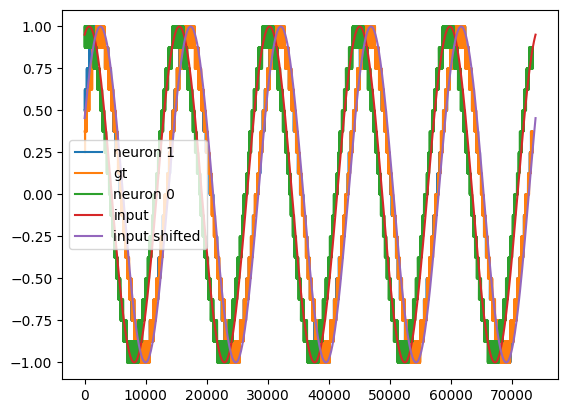

In [139]:
# best_params = study.best_params.copy()
# best_params['lf_lp_option'] = 2

reg_params = {
    'lf_lp_option': 2,
    'theta_gain': -5,
    'weight_gain': 10,
    'amplitude_gain': 1
}
best_params = reg_params
objective_parametrize(**best_params, plot=True)
print(_lf_lp_options[best_params['lf_lp_option']])
best_params

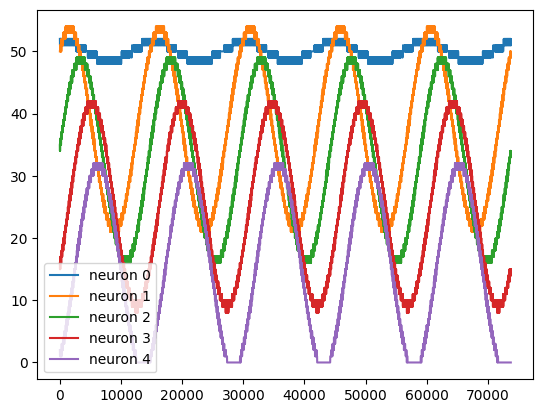

In [142]:


# resonator = resonator_from_optuna(**best_params)
resonator = resonator_from_optuna(**reg_params)
duration = .3
spectrum = duration
spikes_window_size = 100

x = np.linspace(0, spectrum, int(duration * clk_freq))
t = x * 2 * np.pi * freq0
sine_wave = np.sin(t)
resonator.input_full_data(sine_wave)


for i in range(5):
    normalize_roll = neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0, normalize=False)
    plt.plot(normalize_roll, label=f'neuron {i}')
plt.legend()


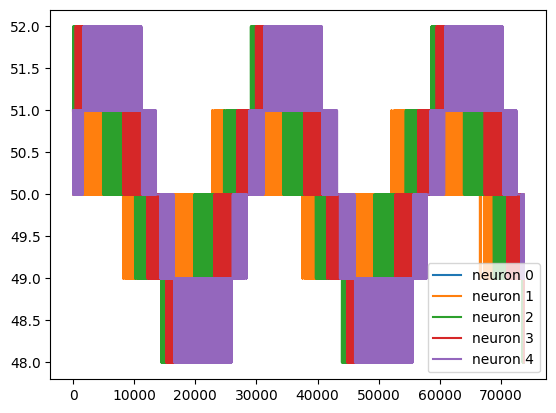

In [125]:

resonator = resonator_from_optuna(**best_params)
duration = .3
spectrum = duration
spikes_window_size = 100

x = np.linspace(0, spectrum, int(duration * clk_freq))
t = x * 2 * np.pi * freq0/2
sine_wave = np.sin(t)
resonator.input_full_data(sine_wave)


for i in range(5):
    normalize_roll = neuron_output(resonator.neurons[i], spikes_window_size, duration, signal_freq=freq0, normalize=False)
    plt.plot(normalize_roll, label=f'neuron {i}')
plt.legend()


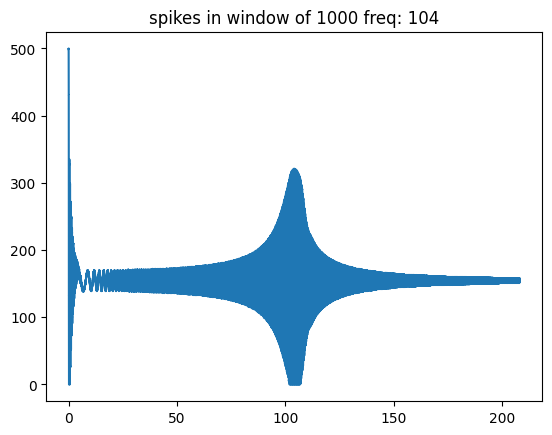

In [141]:
start_freq = 0
spectrum = 2 * freq0
# resonator = resonator_from_optuna(**best_params)

resonator = resonator_from_optuna(**reg_params)
# resonator = resonator_from_optuna(lf_lp_option=2, theta_gain=-5, amplitude_gain=10, weight_gain=10)
step = 1 / 50000
test_size = int(spectrum / step)
test_resonator_on_chirp(
    resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

spikes_neuron = resonator.neurons[-1]
y_events = spikes_neuron.out_spikes()
y_spikes = np.zeros(test_size)
y_spikes[y_events] = 1
spikes_window_size = 1000
y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))
plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
plt.plot(x, y_spikes)
plt.show()

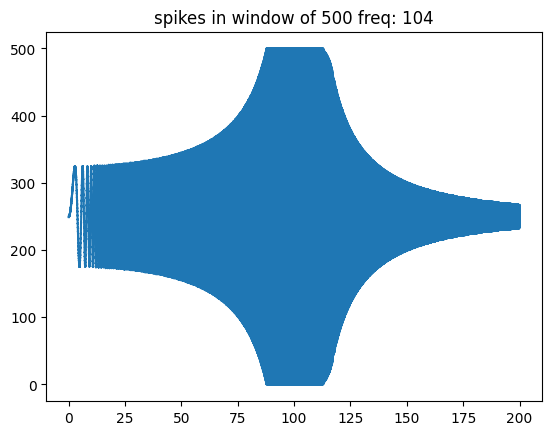

In [44]:
from numba import njit
from snn.resonator import create_base_resonator, create_chirp_signal

start_freq = 0
spectrum = 200
freq0 = 104
resonator = create_base_resonator(freq0=f'{freq0}', clk_freq=clk_freq)
resonator.log_out_spikes(-1)
step = 1 / 100000
test_size = int(spectrum / step)

test_resonator_on_chirp(
    resonator,
    start_freq=start_freq,
    step=step,
    test_size=test_size,
    clk_freq=clk_freq
)

spikes_neuron = resonator.neurons[-1]
y_events = spikes_neuron.out_spikes()
y_spikes = np.zeros(test_size)
y_spikes[y_events] = 1
spikes_window_size = 500
y_spikes = np.convolve(y_spikes, np.ones(spikes_window_size, dtype=int), 'valid')
x = np.linspace(start_freq, start_freq+spectrum, len(y_spikes))
plt.title(f'spikes in window of {spikes_window_size} freq: {freq0}')
plt.plot(x, y_spikes)
plt.show()